In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import BoundaryNorm
from astropy.io import fits
from astropy.table import Table
from pathlib import Path
import os
import math
import glob
from PIL import Image

In [2]:
tablename = 'C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\jvds_stelkin_cat_v012_mge_seecorr_kh20_v150121_private-Copy1.fits'
cat = Table.read(tablename, hdu=1)

In [16]:
# make an array for each important dataset
CATID = cat.field('CATID')
CATID_EXT = cat.field('CATID_EXT')
LMSTAR = cat.field('LMSTAR')
KIN_MTYPE = cat.field('KIN_MTYPE')
RE_CIRC_KPC = cat.field('RE_CIRC_KPC')
SIGMA_RE = cat.field('SIGMA_RE')

In [17]:
#define some constants for calculation of SIGMA_STAR

MSOLAR = 1.98892e30
G = 6.67300e-11
kpctom = 3.08568025e19

#function to calculate SIGMA_STAR

def SIGMA_STAR_CALC(LMSTAR_VAL, RE_CIRC_VAL):
    return math.sqrt(((10**LMSTAR_VAL)*MSOLAR*G)/(RE_CIRC_VAL*kpctom*5))/(1e3)

#CALCULATE SIGMA_STAR and replace nans of SIGMA_RE with SIGMA_STAR

SIGMA_STAR = []
for i in range(LMSTAR.size):
    SIGMA_STAR += [SIGMA_STAR_CALC(LMSTAR[i],RE_CIRC_KPC[i])]
    
SIGMA_STAR = np.array(SIGMA_STAR)

NANS_SIGMA_RE = np.argwhere(np.isnan(SIGMA_RE))
SIGMA_STAR_1 = SIGMA_STAR[NANS_SIGMA_RE]
SIGMA_RE[NANS_SIGMA_RE] = SIGMA_STAR_1

In [18]:
# Create an array of the CATID_EXT where the KIN_MTYPE is lower than 6
classified = CATID[np.where(KIN_MTYPE < 6)] 

In [59]:
# Create an array of the CATID_EXT where the KIN_MTYPE is lower than 4
classified_1 = CATID[np.where(KIN_MTYPE < 4)] 
classified_1_labels = KIN_MTYPE[np.where(KIN_MTYPE < 4)]
classified_1_sigma_re = SIGMA_RE[np.where(KIN_MTYPE < 4)]

In [48]:
classified_test = classified_1[0:10]

In [64]:
training_data_1 = []

for i in range(0,np.size(classified_1)):

    catid_use = classified_1[i]
    # search for file name
    catid_use = str(catid_use)
    filename = (glob.glob('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\two_moments\\'+catid_use+'*.fits'))
    filename = str(filename[0])
    data = fits.open(filename)
    # open the velocity & error & snr
    vel = data['VEL'].data
    vel_err = data['VEL_ERR'].data
    # sig = data['SIG'].data
    # sig_err = data['SIG_ERR'].data
    qc = data['QC'].data
    snr = qc[:,:,3]

    #find where the conditions are met and filter out bad values

    a = np.where((vel_err < 30) & (snr > 3), 1, np.NaN)
    vel = np.multiply(vel,a)

    centre = vel[23:26,23:26]
    median = np.nanmedian(centre)
    vel = vel - median

    SIGMA_SCALE = classified_1_sigma_re[i]

    if np.isnan(SIGMA_SCALE) == True:
        SIGMA_SCALE = np.nanpercentile(np.absolute(vel),95)
    else:
        SIGMA_SCALE = SIGMA_SCALE

    vel = np.where(vel > SIGMA_SCALE, SIGMA_SCALE, vel)
    vel = np.where(vel < -SIGMA_SCALE, -SIGMA_SCALE, vel)

    mean = np.nanmean(vel)
    vel = np.nan_to_num(vel, mean)

    vel = (vel - np.nanmin(vel))/(np.nanmax(vel) - np.nanmin(vel))
    
    class_num = classified_1_labels[i]
    
    training_data_1.append([vel, class_num])


# plt.pcolor(vel, cmap = "RdYlBu_r")
# plt.colorbar()

# figure out how to save new 2D array (old method if nec as only doing 538 iterations)

# scale the array using sigma to ensure that there is good variation and that the plots will look similar

# make sure that the nan values are in the middle of the array

# save the dataset as numpy arrays and then perform 5-fold cross validation on the data

# figure out a way to plot the data that it gets wrong so that I can visually determine if there are any similarities 
# in the errors or correct answers

# using the 5 fold validation method (coding tab) to make a list of incorrect maps and then separately plot?

# create a confusion matrix of validation dataset for each of the five datasets

# combine this notebook with create datasets colab and save into github

# vel_flat = np.ndarray.flatten(vel)
# abs_vel = np.absolute(vel_flat)
# print(np.nanpercentile(abs_vel, 90

C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


In [65]:
np.shape(training_data_1)

(538, 2)

In [67]:
X = []
y = []

for features, label in training_data_1:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, 50,50, 1)
y = np.array(y)

In [70]:
os.chdir('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\')

In [71]:
X_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\KIN_TRAINING_DATA\\X', X)
y_vals_classified = np.save('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\KIN_TRAINING_DATA\\y', y)

In [12]:
hdul = fits.open(SAMI_FITS[1])

In [62]:
np.shape(training_data_1)

(9, 2)

In [20]:
VMAP = hdul[3].data
VEL_ERR = hdul[4].data
SIG = hdul[5].data
SIG_ERR = hdul[6].data
QC = hdul[8].data
SNR = QC[:,:,3]

In [26]:
np.shape(SNR)

(50, 50)

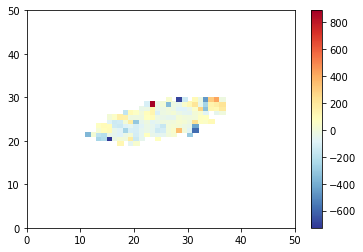

In [30]:
plt.pcolor(VMAP, cmap = 'RdYlBu_r')
plt.colorbar()

In [27]:
np.shape(VEL_ERR)

(50, 50)

In [24]:
VMAP_good = np.where((SNR > 3) & (VEL_ERR < 30))

C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [25]:
np.shape(VMAP_good)

(2, 13)

In [ ]:
SNR = np.where(SNR > 3, 1, np.NaN)
SIG_ERR = np.where(SIG_ERR < SIG*0.1 +25, 1, np.NaN)
VEL_ERR = np.where(VEL_ERR < 30, 1, np.NaN)



In [36]:
 for a in range (0,100):
    os.chdir('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\two_moments')
    
    data_folder = Path()
    file_to_open = data_folder / SAMI_FITS[a]
    hdul = fits.open(file_to_open)
    VMAP = hdul[3].data
    VEL_ERR = hdul[4].data
    SIG = hdul[5].data
    SIG_ERR = hdul[6].data

    QC = hdul[8].data
    SNR = QC[:,:,3]

    SNR = np.where(SNR > 3, 1, np.NaN)
    SIG_ERR = np.where(SIG_ERR < SIG*0.1 +25, 1, np.NaN)
    VEL_ERR = np.where(VEL_ERR < 30, 1, np.NaN)

    VMAP = VMAP[]
    
    SIG = np.multiply(SIG,SIG_ERR)
    SIG = np.multiply(SIG,SNR)
    SIG_BOTH = np.multiply(SIG, VEL_ERR)

    VMAP = np.multiply(VMAP,VEL_ERR)
    VMAP = np.multiply(VMAP,SNR)
    # VMAP_BOTH = np.multiply(VMAP, SIG_ERR)

    VMAP_CENTRE = VMAP[23:26,23:26]
    MEDIAN = np.nanmedian(VMAP_CENTRE)
    VMAP = VMAP - MEDIAN

    CATID1 = int(hdul[0].header[14])
    x = np.where(CATID == CATID1)
    y = np.nanmax(x)
    SIGMA_SCALE = SIGMA_RE[y]

    if np.isnan(SIGMA_SCALE) == True:
        SIGMA_SCALE = np.nanpercentile(VMAP,95)
    else:
        SIGMA_SCALE = SIGMA_SCALE
    
    VMAP = np.where(VMAP < SIGMA_SCALE, VMAP, SIGMA_SCALE)
    VMAP = np.where(VMAP > -SIGMA_SCALE, VMAP, -SIGMA_SCALE)
    
    VMAP = (VMAP - np.nanmin(VMAP))/(np.nanmax(VMAP) - np.nanmin(VMAP))
    where_are_nans = np.isnan(VMAP)
    VMAP[where_are_nans] = 2
 
#     VMAP = np.nan_to_num(VMAP)
    
    for i in range (0,np.size(x)):
        
        label = x[0]
        label = float(KIN_MTYPE[label[i]])
        if label == 6.0:
            continue
        else:
            label = str(label)
        
        os.chdir('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING_DATA\\' + label)
        
        np.save("VMAP_" + str(CATID1) + "_" + str(i+1) + ".npy", VMAP)


C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less
C:\Users\hepbu\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
C:\Users\hepbu\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


In [56]:
lab = KIN_MTYPE[x]
lab = str(int(lab))
KIN_MTYPE[1:6]



array([6., 6., 6., 0., 6.], dtype=float32)

<function matplotlib.pyplot.show(*args, **kw)>

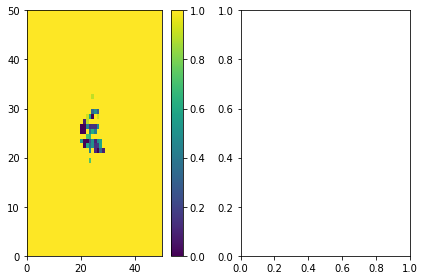

In [50]:
fig, axs = plt.subplots(1,2)

D = axs[0].pcolor(VMAP)
fig.colorbar(D, ax = axs[0])
plt.tight_layout()
plt.show

In [30]:
aaaa = [[6,6,6,6,5], [0,1,2,3,5]]
aaaa = np.array(aaaa)
ab = np.where(aaaa > 4)
ab[1]

array([0, 1, 2, 3, 4, 4], dtype=int64)

In [79]:
list_1 = x[0]
list_1[0]

529

In [72]:
type(index)

numpy.ndarray

In [54]:
aaa = str(lab)
os.chdir('C:\\Users\\hepbu\\Documents\\2021\\Honours Project\\SAMI DATA\\TRAINING DATA\\' + lab)

In [84]:
np.save("VMAP1.npy", VMAP)

In [86]:
float(2.5)

2.5